In [2]:
# download and extract movielens dataset
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2020-02-17 20:23:43--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K   765KB/s    in 1.2s    

2020-02-17 20:23:45 (765 KB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [1]:
# data inspection and preprocessing
import pandas as pd
from IPython.display import display

download_dir = './ml-latest-small'
links = pd.read_csv(download_dir + '/links.csv')
display(links.head())
tag = pd.read_csv(download_dir + '/tags.csv')
display(tag.head())
ratings = pd.read_csv(download_dir + '/ratings.csv')
display(ratings.head())
movies = pd.read_csv(download_dir + '/movies.csv')
movies.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


For this dataset, the movies are provided genres, and the time of ratings are given. Both are useful information, however the former are not usually given in a collaborative filtering setting. The latter can tell us how the user profile has changed over years, this will be used in part II of this experiment.

In [2]:
# left join genres onto ratings table
df = ratings.join(movies.set_index('movieId'), on='movieId')
# turn timestamp from seconds to year
change_to_year = lambda x: pd.Timestamp(x, unit='s').year
df.timestamp = df.timestamp.apply(change_to_year)
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,2000,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,2000,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,2000,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,2000,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,2000,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [3]:
# to numerically encode features and create mapping for them
userId_map = {}
userId_set = set(df.userId.tolist())
for i, userId in enumerate(userId_set):
    userId_map[userId] = i

movieId_map = {}
movieId_set = set(df.movieId.tolist())
for i, movieId in enumerate(movieId_set):
    movieId_map[movieId] = i

### Part I: Generalized matrix factorization (a.k.a low rank k matrix approximation)

minimize (p, q, $b_i$, $b_u$) $$\sum_{(u, i)\in K} (r_{ui} - q_i^T.p_u - \mu_i - b_i - b_u)^2 + \lambda(|q_i|^2 + |p_u|^2 + |b_i|^2 + |b_u|^2)$$

where $q_i$, $p_u$ are the feature vectors or embeddings for movie i and user u respectively, K is the set that the rating is made for movie i from user u, $b_i$ and $b_u$ are the bias units and $\lambda$ is our regularization hyperparameter, subtracting the $\mu$ (mean rating for movie i) is to make sure that when doing gradient descent, due to regularization, the model will not tend to predict the rating to be 0, instead, it will tend to be the mean value for movie i.

For more detail, refer to the <a href='http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.173.2797&rep=rep1&type=pdf'>original paper</a> by Yunhong Zhou. et al in 2008.

In [4]:
import numpy as np
import torch

n_movies = len(df.movieId.unique())
n_users = len(df.userId.unique())
hidden_d = 100

# prepare the mean rating vector for movies
mu = df.groupby(['movieId']).mean()['rating']

In [5]:
# numercially encode movieId, userId and create mapping
movie_map = set(df.movieId.tolist())
movie_map = {movie:i for i, movie in enumerate(movie_map)}

user_map = set(df.userId.tolist())
user_map = {user:i for i, user in enumerate(user_map)}

In [6]:
mu = mu.reset_index()
mu.movieId = mu.movieId.apply(lambda x: movie_map[x])
mu = mu.sort_values(by=['movieId'])
mu = torch.Tensor(mu.rating.tolist())

In [7]:
# define neural network architechture in pytorch
import torch.nn as nn
import torch.nn.functional as F


class classicalNet(nn.Module):
    def __init__(self, n_movies, n_users, hidden_d, mu):
        super(classicalNet, self).__init__()
        self.W1 = torch.rand((hidden_d, n_movies), requires_grad=True)
        self.W2 = torch.rand((hidden_d, n_users), requires_grad=True)
        self.b1 = torch.rand(n_movies, requires_grad=True)
        self.b2 = torch.rand(n_users, requires_grad=True)
        # dimension: n_movies
        self.mu = mu
        
    def forward(self, x1, x2):
        "x1: n_movies by batch_dimension"
        "x2: n_users by batch_dimension"
        
        # get movie no.
        i = torch.argmax(x1, dim=0)
        # get user no.
        u = torch.argmax(x2, dim=0)
        
        x1 = torch.mm(self.W1, x1)
        x1 = x1.t()
        x2 = torch.mm(self.W2, x2)
        
        x = torch.zeros(x2.size(1))
        for k in range(x2.size(1)):
            x[k] += torch.dot(x1[k], x2[:, k]) + self.mu[i[k]] + self.b1[i[k]] + self.b2[u[k]]
            
        # below is a bad example by rewrapping a tensor, this break the computation graph and results in grad==None
        
#         x = torch.tensor([torch.dot(x1[k], x2[:, k]) for k in range(x2.size(1))], requires_grad=True)
        
#         x = x + torch.tensor([self.mu[i[k]] for k in range(x2.size(1))]) \
#                 + torch.tensor([self.b1[i[k]] for k in range(x2.size(1))]) \
#                 + torch.tensor([self.b2[u[k]] for k in range(x2.size(1))])
        
        return x
    
    def rmseloss(self, pred, r):
        "pred, ratings: batch_dimension"

        loss = torch.tensor(0.)
        count = 0
        
        # implement MSE loss assuming not all ratings are present in r
        for k in range(r.size(0)):
            if ~torch.isnan(r[k]):
                loss += (pred[k] - r[k])**2
                count += 1
        
        # regularization with lambda=0.0001
        loss += 0.0001 * ((self.W1 * self.W1).sum() + (self.W2 * self.W2).sum() \
                                            + (self.b1 * self.b1).sum() + (self.b2 * self.b2).sum())
        loss = loss / count
        return loss**0.5

classical_net = classicalNet(n_movies, n_users, hidden_d, mu)

In [8]:
import torch.optim as optim
optimizer = optim.Adam([classical_net.W1, classical_net.W2, classical_net.b1, classical_net.b2], lr=0.001)

In [9]:
# prepare train, validation, test sets
X = df.iloc[:, 0:2]
y = df.iloc[:, 2]

from sklearn.model_selection import train_test_split
# 70% train, 21% validation, 9% test
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.3, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_validation, y_validation, test_size=0.3, random_state=41)

In [10]:
# generate tensor for pytorch model's input and output for SGD
def batch_generator(X, y, batch_size):
    for i in range(X.shape[0]//batch_size):
        batch_input = X.iloc[i*batch_size: i*batch_size + batch_size]
        batch_output = y.iloc[i*batch_size: i*batch_size + batch_size]

        movie_input = []
        user_input = []
        rating_output = []
        
        for _, input_ in batch_input.iterrows():
            user_vector = np.zeros(len(user_map))
            user_vector[user_map[input_.userId]] = 1.
            user_input.append(user_vector)
                    
            movie_vector = np.zeros(len(movie_map))
            movie_vector[movie_map[input_.movieId]] = 1.
            movie_input.append(movie_vector)

        for _, output in batch_output.iteritems():
            rating_output.append(output)
        
        # make sure torch.float for backprop
        movie_input = torch.tensor(movie_input, dtype=torch.float32)
        user_input = torch.tensor(user_input, dtype=torch.float32)
        # for tensor of dimension, n_movies by batch_no
        movie_input = movie_input.t()
        user_input = user_input.t()
        rating_output = torch.tensor(rating_output, dtype=torch.float32)

        yield movie_input, user_input, rating_output

In [11]:
sample_size = 5000
X_validation_sample = X_validation.iloc[:sample_size]
y_validation_sample = y_validation.iloc[:sample_size]

X_training_sample = X_train.iloc[:sample_size]
y_training_sample = y_train.iloc[:sample_size]

def loss_check(model, X, y):
    with torch.no_grad():
        X_movie, X_user, y_rating = list(batch_generator(X, y, len(X)))[0]
        prediction = model(X_movie, X_user)
        return model.rmseloss(prediction, y_rating).item()

In [15]:
def training(n_epoch):
    # loop over the dataset multiple times
    batch_size = 1024
    validation_history = []
    training_history = []
    patience = 3

    for epoch in range(n_epoch):

        running_loss = 0.0
        batch_no = 0
        for movie_input, user_input, rating in batch_generator(X_train, y_train, batch_size):

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = classical_net(movie_input, user_input)
            loss = classical_net.rmseloss(outputs, rating)
            loss.backward()
            
            # check for normal behavior of batch gradient descent
            # only leaf node get grad, in typical nn, all parameters are leaf nodes
            if batch_no == 0 and epoch == 0:    
                print(loss.grad, loss.is_leaf)
                print(classical_net.W1.grad, classical_net.W1.is_leaf)
                print(classical_net.W2.grad, classical_net.W2.is_leaf)
                print(classical_net.b1.grad, classical_net.b1.is_leaf)
                print(classical_net.b2.grad, classical_net.b2.is_leaf)
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if batch_no % 30 == 29:
                print('[{}, {}] average_loss per batch: {}'.format(epoch+1, batch_no+1, running_loss/30))
                running_loss = 0.0

            batch_no += 1

        # check training and validation loss after every epoch
        training_loss = loss_check(classical_net, X_training_sample, y_training_sample)
        print('training_loss: {}'.format(training_loss))
        training_history.append(training_loss)
        vali_loss = loss_check(classical_net, X_validation_sample, y_validation_sample)
        print('validation_loss: {}'.format(vali_loss))
        validation_history.append(vali_loss)
        
        if len(validation_history) >= patience:
            # either validation_loss doesnt improve or model starts to overfit
            if abs(validation_history[-1] - validation_history[-patience]) / validation_history[-patience] < 0.005\
                                                        or validation_history[-1] > validation_history[-patience]:
                print('Early stopping')
                break

    print('Finished Training')
    return validation_history, training_history

n_epoch = 30
validation_history, training_history = training(n_epoch)

None False
tensor([[9.2125e-04, 5.3908e-04, 2.9790e-05,  ..., 3.5250e-10, 1.3638e-09,
         1.8333e-09],
        [6.1690e-04, 7.7889e-04, 4.2534e-04,  ..., 1.9517e-09, 3.0922e-09,
         1.6568e-09],
        [1.0792e-03, 8.0708e-04, 3.8648e-04,  ..., 2.0125e-09, 2.0011e-09,
         1.6532e-11],
        ...,
        [7.7293e-04, 5.7279e-04, 5.3417e-04,  ..., 1.7969e-09, 2.8181e-09,
         2.5089e-09],
        [1.4738e-03, 1.5810e-04, 9.8194e-05,  ..., 9.0100e-10, 9.3269e-11,
         7.9214e-10],
        [1.5004e-03, 7.1684e-04, 5.9747e-04,  ..., 1.3143e-09, 9.7395e-10,
         2.3794e-09]]) True
tensor([[1.4209e-03, 3.2698e-09, 1.7994e-09,  ..., 2.8940e-03, 9.9192e-10,
         4.3054e-03],
        [1.9449e-03, 2.2035e-09, 4.3314e-10,  ..., 3.2645e-03, 1.7121e-09,
         6.5289e-03],
        [1.5263e-03, 1.0992e-09, 2.9595e-09,  ..., 3.9215e-03, 1.8328e-09,
         5.1936e-03],
        ...,
        [2.6547e-03, 7.6003e-10, 2.0156e-09,  ..., 2.9230e-03, 1.3724e-09,
         

[1, 30] average_loss per batch: 25.320961825052898
[1, 60] average_loss per batch: 23.435988171895346
training_loss: 22.06778907775879
validation_loss: 22.04291534423828
[2, 30] average_loss per batch: 21.251647504170737
[2, 60] average_loss per batch: 19.557798767089842
training_loss: 18.401865005493164
validation_loss: 18.386045455932617
[3, 30] average_loss per batch: 17.671925226847332
[3, 60] average_loss per batch: 16.16515153249105
training_loss: 15.184741973876953
validation_loss: 15.18737506866455
[4, 30] average_loss per batch: 14.536856619517009
[4, 60] average_loss per batch: 13.205230681101481
training_loss: 12.375256538391113
validation_loss: 12.399706840515137
[5, 30] average_loss per batch: 11.802329794565837
[5, 60] average_loss per batch: 10.630350462595622
training_loss: 9.93094539642334
validation_loss: 9.980087280273438
[6, 30] average_loss per batch: 9.426313050587972
[6, 60] average_loss per batch: 8.400098609924317
training_loss: 7.816278457641602
validation_los

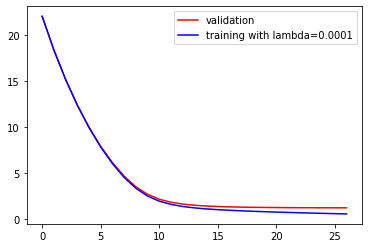

In [17]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(validation_history)), validation_history, color='r', label='validation')
plt.plot(np.arange(len(training_history)), training_history, color='b', label='training with lambda=0.0001')
plt.legend()
plt.show()

In [18]:
# lets see how gd our model prediction's are on the test set
test_loss = loss_check(classical_net, X_test, y_test)
print('test_loss: {}'.format(test_loss))

# demo compared to ground truth
with torch.no_grad():
    X_sample, y_sample = X_test[:10], y_test[:10]
    sample_movie, sample_user, rating_truth = list(batch_generator(X_sample, y_sample, len(X_sample)))[0]
    print('prediction rating: {}'.format(classical_net(sample_movie, sample_user).numpy()))
    print('ground truth rating: {}'.format(rating_truth.numpy()))

test_loss: 1.1937782764434814
prediction rating: [4.3500695 2.9137022 4.3469987 2.7329993 2.798546  1.7702787 3.4639726
 4.969605  3.5159373 4.4113164]
ground truth rating: [4.5 3.5 4.  5.  4.  2.5 3.  4.  4.  4. ]


#### The test loss is close to validation loss, which is a good sign of the experimentation.

In [19]:
# save model
PATH = './30_epochs-classical_MFnn_earlyStopping.pth'
torch.save(classical_net.state_dict(), PATH)

### Compare to good old SVD method

In [20]:
from sklearn.decomposition import TruncatedSVD
# form our movie-user-rating matrix
r = np.zeros((n_movies, n_users))
for _, row in X_train.iterrows():
        r[movie_map[row.movieId], user_map[row.userId]] = y_train[_]

# for x = usvT
svd = TruncatedSVD(n_components=100, random_state=41)

# movie_embedd: (n_movies, 100) which is us, the product of left singular and diagonal matrix
movie_embedd = svd.fit_transform(r)
print('explained_variance ratio for 100 components movie_embedd: {}'.format(sum(svd.explained_variance_ratio_)))

# user_embedd: (n_movies, 100) which is v, the right singular matrix
user_embedd = svd.fit_transform(r.T)
for k in range(len(svd.singular_values_)):
    user_embedd[:, k] /= svd.singular_values_[k]
print('explained_variance ratio for 100 components user_embedd: {}'.format(sum(svd.explained_variance_ratio_)))

with torch.no_grad():
    loss = 0.
    for _, sample in X_test.iterrows():
        prediction = np.dot(user_embedd[user_map[sample.userId]], movie_embedd[movie_map[sample.movieId]])
        loss += (y_test[_] - prediction)**2
    print('rmseloss on test set by SVD method: {}'.format((loss/X_test.shape[0])**0.5))

explained_variance ratio for 100 components movie_embedd: 0.6717697007444805
explained_variance ratio for 100 components user_embedd: 0.6590705302792939
rmseloss on test set by SVD method: 3.5207387628519533


Compared to the SGD result of loss around 1.19, this is rather impressive for such a simple model, however, it is now proven that nn based GMF do better than plain SVD on sparse dataset.

### Shortcomings for generalized matrix factorization 
1. cannot incorporate other source of information like change of taste over time other than user, movie embeddings
2. only dot product and bias units are used to capture user movie interations
3. can deep network help to learn the functional form of interation between embeddings, or even with other features?

By Xiangnan He. et al, <a href='https://arxiv.org/pdf/1708.05031.pdf'>Neural Collaborative Filtering</a> in 2017, they proposed the following architecture and claimed to have performance, in part II of this experiment, we shall explore this setup.
<img src='./deep_cl.png' height='700px' width='500px'>

### Part II: NeuMF machine